### Base Template with Perlin Noise Procedural Generative Environment 

In [71]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, context:int, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            context (int): either 0 or 1, 0 for roads while 1 for walkways
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.context = context

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "coordinates": spaces.Box(low=-1, high=3, shape=(self.maximum_planting_spots, 6), dtype=np.float32),
            "theme": spaces.Discrete(2)
            }
        )
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)


        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = round((xcoord-boundary[0]) / x_length, 4)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = round((ycoord-boundary[2]) / y_length, 4)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)

    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, x coordinate, y coordinate, classified?, class] -> [0-1, 0-1, 0-100, 0-100, 0/1, 0/1/2/3]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
       
        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            normalised_planting_list[i] = ratio_coords + (planting_coords[1]/100, planting_coords[0]/100) + (0, 0)
        
        return normalised_planting_list


    def _get_observation(self):
        return {
            "coordinates": self.normalised_planting_list,
            "theme": self.context
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        # Classify class
        if class_value < 0.33:
            plant_class = 1 # tree
        
        elif class_value < 0.66:
            plant_class = 2 # shrub
        
        else:
            plant_class = 3 # n.a

        # Retrieve closest point from action
        # TODO: look into if a boundary is needed
        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward -= 50
            
        chosen_value = self.normalised_planting_list[chosen_index]
        if int(chosen_value[4]) == 1: #Already planted
            reward -= 20
        
        else:
            if plant_class == 1:
                all_tree_coordinates = self.normalised_planting_list[self.normalised_planting_list[:, -1] == 1]
                tree_distances = np.linalg.norm(all_tree_coordinates[:, 2:4] - np.array([chosen_value[2], chosen_value[3]]), axis=1)
                # For every tree that is less than 50 grid apart
                # All coordinates are scaled down by 100
                for distance in tree_distances:
                    if distance < 50/100:
                        reward -= 15
                    else:
                        reward += 15

            # All tree criterias met
            if reward >= 0:
                chosen_value[4] = 1 
                chosen_value[5] = plant_class 

                # Update grid and planting list
                self.grid[int(round(chosen_value[3]*100)), int(round(chosen_value[2]*100))] = plant_class + 1
                self.normalised_planting_list[chosen_index] = chosen_value
                
                # Check context to reward accordingly
                if self.context == 0: # road context
                    reward = self._road_reward(chosen_value)

                elif self.context == 1: # walkway context
                    reward = self._walkway_reward(chosen_value)

        # All planted
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:float, yratio:float):
        # Remove padded coordinates
        padding_mask = ~(self.normalised_planting_list[:, :2] == -1).all(axis=1)
        filtered_planting_list = self.normalised_planting_list[padding_mask]

        # Calculate distance of all plantable coordinates to RL action
        distances = np.linalg.norm(filtered_planting_list[:, :2] - np.array([xratio, yratio]), axis=1)

        if np.min(distances) < 0.2:
            # Retrieve the data of the closest value
            closest_index = np.argmin(distances)

        else:
            closest_index = -1

        return closest_index


    def _road_reward(self, chosen_value):
        # Near boundary
        if min(chosen_value[0], chosen_value[1]) <=0.2 or max(chosen_value[0], chosen_value[1]) >= 0.8:
            if chosen_value[-1] == 1: # reward trees
                return 30

            elif chosen_value[-1] == 2: # punish shrubs
                return -5
            
            else:
                return 0 # nothing
        
        else:
            if chosen_value[-1] == 3: # nothing
                return 0
            return 20 # regardless of tree / shrub, reward


    def _walkway_reward(self, chosen_value):
        # Near walkway
        if min(chosen_value[0], chosen_value[1]) <=0.2 or max(chosen_value[0], chosen_value[1]) >= 0.8:
            if chosen_value[-1] == 2: # reward shrubs
                return 30

            elif chosen_value[-1] == 1: # reward trees lesser
                return 10 
            
            else:
                return 0
        
        else:
            if chosen_value[-1] == 3: # nothing
                return 0
            
            return 20 # regardless of tree / shrub, reward
        

    def render(self):
        value_to_colour = {
            0: (169/255, 169/255, 169/255) if self.context ==0 else (102/255, 0, 0),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()



In [ ]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customSpatialEnv(random.randint(0,1), random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [37]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(context, octave):
    def _init():
        return customSpatialEnv(context, octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.randint(0,1), random.uniform(1,2)) for env in range(30)])

In [ ]:
import gc
gc.collect()

In [39]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 30,
             verbose=0)

In [41]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super(EpisodeRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_count = 0
        self.episode_rewards = 0
    
    def _on_step(self) -> bool:
        # Accumulate the reward of the current step
        self.episode_rewards += self.locals['rewards'][0]
        
        # Check if a new episode has started
        if self.locals['dones'][0]:
            self.episode_count += 1

            if self.episode_count % self.check_freq == 0:
                # Print the total reward of the 100th episode
                print(f"Episode {self.episode_count}: Total Reward = {self.episode_rewards}")
            
            # Reset episode reward for the next episode
            self.episode_rewards = 0

        return True

# Create the callback instance
reward_callback = EpisodeRewardCallback(check_freq=5)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 50000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))

In [ ]:
eval_env = customSpatialEnv(random.randint(0,1), random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        break

In [14]:
model.save('models/PPO_2.zip')

In [ ]:
model2 = model.load('models/PPO_2.zip')

In [ ]:
eval_env = customSpatialEnv(random.randint(0,1), random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        break

### Trying discrete action space

In [107]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteSpatialEnv(gym.Env):
    def __init__(self, context:int, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            context (int): either 0 or 1, 0 for roads while 1 for walkways
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteSpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 500

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.context = context

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "coordinates": spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 6), dtype=np.float32),
            "theme": spaces.Discrete(2)
            }
        )
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)


        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, x coordinate, y coordinate, classified?, class] -> [0-1, 0-1, 0-100, 0-100, 0/1, 0/1/2/3]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
       
        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            normalised_planting_list[i] = ratio_coords + (planting_coords[1]/10, planting_coords[0]/10) + (0, 0)
        
        return normalised_planting_list


    def _get_observation(self):
        return {
            "coordinates": self.normalised_planting_list,
            "theme": self.context
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2] + 1

        # Retrieve closest point from action
        # TODO: look into if a boundary is needed
        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            valid_targets = self.normalised_planting_list[self.normalised_planting_list[:, -2] == 0]  # Where the last element is 0
            distances = np.linalg.norm(valid_targets[:, :2] - np.array([x_ratio, y_ratio]), axis=1)
            min_distance = np.min(distances)
            reward -= 3**min_distance

        else:
            reward += 50
            chosen_value = self.normalised_planting_list[chosen_index]
            chosen_value[-2] = 1
            chosen_value[-1] = class_value
            self.normalised_planting_list[chosen_index] = chosen_value
            self.grid[int(round(chosen_value[3]*10)), int(round(chosen_value[2]*10))] = class_value + 1
        
        if self.current_step > 100:
            reward -= (self.current_step - 100)

        # All planted
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick value
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -2].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
        

    def render(self):
        value_to_colour = {
            0: (169/255, 169/255, 169/255) if self.context ==0 else (102/255, 0, 0),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()



In [ ]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteSpatialEnv(random.randint(0,1), random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [98]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(context, octave):
    def _init():
        return customDiscreteSpatialEnv(context, octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.randint(0,1), random.uniform(1,2)) for env in range(30)])

In [ ]:
import gc
gc.collect()

In [100]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 15,
             n_epochs= 10,
             batch_size= 15 * 30,
             verbose=0)

In [69]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super(EpisodeRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_count = 0
        self.episode_rewards = 0
    
    def _on_step(self) -> bool:
        # Accumulate the reward of the current step
        self.episode_rewards += self.locals['rewards'][0]
        
        # Check if a new episode has started
        if self.locals['dones'][0]:
            self.episode_count += 1

            if self.episode_count % self.check_freq == 0:
                # Print the total reward of the 100th episode
                print(f"Episode {self.episode_count}: Total Reward = {self.episode_rewards}")
            
            # Reset episode reward for the next episode
            self.episode_rewards = 0

        return True

# Create the callback instance
reward_callback = EpisodeRewardCallback(check_freq=5)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 10000
total_timesteps = max_runs* 15

model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))


In [ ]:
eval_env = customDiscreteSpatialEnv(random.randint(0,1), random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        break

### Density Chart

In [106]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import math

# Environment Class
class customDensitySpatialEnv(gym.Env):
    def __init__(self, context:int, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            context (int): either 0 or 1, 0 for roads while 1 for walkways
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDensitySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.context = context

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        self.planting_class_count = {1: 0, 2:0, 3:0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "coordinates": spaces.Box(low=-1, high=3, shape=(self.maximum_planting_spots, 6), dtype=np.float32),
            "theme": spaces.Discrete(2)
            }
        )
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = round((xcoord-boundary[0]) / x_length, 4)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = round((ycoord-boundary[2]) / y_length, 4)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)

    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, x coordinate, y coordinate, classified?, class] -> [0-1, 0-1, 0-100, 0-100, 0/1, 0/1/2/3]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
       
        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            normalised_planting_list[i] = ratio_coords + (planting_coords[1]/100, planting_coords[0]/100) + (0, 0)
        
        return normalised_planting_list


    def _get_observation(self):
        return {
            "coordinates": self.normalised_planting_list,
            "theme": self.context
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        # Classify class
        if class_value <= 0.45:
            plant_class = 1 # tree
        
        elif class_value <= 0.9:
            plant_class = 2 # shrub
        
        else:
            plant_class = 3 # n.a

        # Retrieve closest point from action
        # TODO: look into if a boundary is needed
        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward -= 50
            
        chosen_value = self.normalised_planting_list[chosen_index]
        if int(chosen_value[4]) == 1: #Already planted
            reward -= 20
        
        else:
            if plant_class == 1:
                all_tree_coordinates = self.normalised_planting_list[self.normalised_planting_list[:, -1] == 1]
                tree_distances = np.linalg.norm(all_tree_coordinates[:, 2:4] - np.array([chosen_value[2], chosen_value[3]]), axis=1)
                # For every tree that is less than 50 grid apart
                # All coordinates are scaled down by 100
                for distance in tree_distances:
                    if distance < 50/100:
                        reward -= 15

            # All tree criterias met
            if reward >= 0:
                chosen_value[4] = 1 
                chosen_value[5] = plant_class 
                self.planting_class_count[plant_class] += 1

                # Update grid and planting list
                self.grid[int(round(chosen_value[3]*100)), int(round(chosen_value[2]*100))] = plant_class + 1
                self.normalised_planting_list[chosen_index] = chosen_value
                
                # Check context to reward accordingly
                if self.context == 0: # road context
                    reward = self._road_reward(chosen_value)

                elif self.context == 1: # walkway context
                    reward = self._walkway_reward(chosen_value)
        
        # All planted
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:float, yratio:float):
        # Remove padded coordinates
        padding_mask = ~(self.normalised_planting_list[:, :2] == -1).all(axis=1)
        filtered_planting_list = self.normalised_planting_list[padding_mask]

        # Calculate distance of all plantable coordinates to RL action
        distances = np.linalg.norm(filtered_planting_list[:, :2] - np.array([xratio, yratio]), axis=1)

        if np.min(distances) < 0.2:
            # Retrieve the data of the closest value
            closest_index = np.argmin(distances)

        else:
            closest_index = -1

        return closest_index


    def _road_reward(self, chosen_value):
        # Near boundary
        if min(chosen_value[0], chosen_value[1]) <=0.1 or max(chosen_value[0], chosen_value[1]) >= 0.9:
            if chosen_value[-1] == 1: # reward trees
                return (5** self.planting_class_count[1])

            elif chosen_value[-1] == 2: # punish shrubs
                return -5
            
            else:
                empty_density = self.planting_class_count[3] / sum(list(self.planting_class_count.values()))
                if empty_density > 0.1 and empty_density != 1:
                    return 10*math.log(1-empty_density)
                if empty_density == 1:
                    return -1000
                return 0 # nothing
        
        else:
            if chosen_value[-1] == 3: # nothing
                empty_density = self.planting_class_count[3] / sum(list(self.planting_class_count.values()))
                if empty_density > 0.1 and empty_density != 1:
                    return 10*math.log(1-empty_density)
                if empty_density == 1:
                    return -1000
                return 0
            
            elif chosen_value[-1] == 2:
                return (5/math.sqrt(self.planting_class_count[2]))

            else:
                return (3** self.planting_class_count[1])


    def _walkway_reward(self, chosen_value):
        # Near walkway
        if min(chosen_value[0], chosen_value[1]) <=0.1 or max(chosen_value[0], chosen_value[1]) >= 0.9:
            if chosen_value[-1] == 2: # reward shrubs
                return self.planting_class_count[2]**2

            elif chosen_value[-1] == 1: # reward trees lesser
                return self.planting_class_count[1]
            
            else:
                empty_density = self.planting_class_count[3] / sum(list(self.planting_class_count.values()))
                if empty_density > 0.1 and empty_density != 1:
                    return 10*math.log(1-empty_density)
                if empty_density == 1:
                    return -1000
                return 0
                    
        else:
            if chosen_value[-1] == 3: # nothing
                empty_density = self.planting_class_count[3] / sum(list(self.planting_class_count.values()))
                if empty_density > 0.1 and empty_density != 1:
                    return 10*math.log(1-empty_density)
                if empty_density == 1:
                    return -1000
                return 0
            
            elif chosen_value[-1] == 2:
                return (5/math.sqrt(self.planting_class_count[2]))**2

            else:
                return (5** self.planting_class_count[1])
    

    def render(self):
        # value_to_colour = {
        #     0: (169/255, 169/255, 169/255) if self.context ==0 else (102/255, 0, 0),
        #     1: (1, 0, 0),
        #     2: (0, 51/255, 25/255),
        #     3: (0, 204/255, 0),
        #     4: (0/255, 204/255, 204/255),
        #     5: (204/255, 255/255, 229/255)
        # }

        value_to_colour = {
            0: (169/255, 169/255, 169/255) if self.context ==0 else (102/255, 0, 0),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()



In [ ]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDensitySpatialEnv(random.randint(0,1), random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [94]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(context, octave):
    def _init():
        return customDensitySpatialEnv(context, octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.randint(0,1), random.uniform(1,2)) for env in range(30)])

In [ ]:
import gc
gc.collect()

In [99]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 30,
             verbose=0)

In [100]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super(EpisodeRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_count = 0
        self.episode_rewards = 0
    
    def _on_step(self) -> bool:
        # Accumulate the reward of the current step
        self.episode_rewards += self.locals['rewards'][0]
        
        # Check if a new episode has started
        if self.locals['dones'][0]:
            self.episode_count += 1

            if self.episode_count % self.check_freq == 0:
                # Print the total reward of the 100th episode
                print(f"Episode {self.episode_count}: Total Reward = {self.episode_rewards}")
            
            # Reset episode reward for the next episode
            self.episode_rewards = 0

        return True

# Create the callback instance
reward_callback = EpisodeRewardCallback(check_freq=5)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 50000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=reward_callback)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))


In [ ]:
eval_env = customDensitySpatialEnv(random.randint(0,1), random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        break

In [ ]:
eval_env = customDensitySpatialEnv(random.randint(0,1), random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        break

### Discrete Boundary

In [1]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 500

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        self.class_count = {1:0, 2:0, 3:0}
        # Observation space
        self.observation_space = spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 6), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)


        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, x coordinate, y coordinate, classified?, class] -> [0-1, 0-1, 0-100, 0-100, 0/1, 0/1/2/3]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
       
        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            normalised_planting_list[i] = ratio_coords + (planting_coords[1]/10, planting_coords[0]/10) + (0, 0)
        
        return normalised_planting_list


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self.normalised_planting_list , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2] + 1

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        chosen_value = self.normalised_planting_list[chosen_index]
        
        if chosen_index == -1:
            # Punish based off distance
            valid_targets = self.normalised_planting_list[self.normalised_planting_list[:, -2] == 0]  # Where the last element is 0
            distances = np.linalg.norm(valid_targets[:, :2] - np.array([x_ratio, y_ratio]), axis=1)
            min_distance = np.min(distances)
            reward -= 2**min_distance

        else:
            # Check the distance of trees
            if class_value == 1:
                all_tree_coordinates = self.normalised_planting_list[self.normalised_planting_list[:, -1] == 1]
                tree_distances = np.linalg.norm(all_tree_coordinates[:, 2:4] - np.array([chosen_value[2], chosen_value[3]]), axis=1)
                # For every tree that is less than 50 grid (5 in terms of scale here)
                for distance in tree_distances:
                    if distance < 5:
                        reward -=15
            
            if reward >= 0:
                # Update the data accordingly
                chosen_value[-2] = 1
                chosen_value[-1] = class_value
                self.normalised_planting_list[chosen_index] = chosen_value
                # Update grid
                self.grid[int(round(chosen_value[3]*10)), int(round(chosen_value[2]*10))] = class_value + 1
                # Update class
                self.class_count[class_value] += 1

                # Check theme value
                if min(x_ratio, y_ratio) <= 1 or max(x_ratio, y_ratio) >=8:
                    if class_value == 1:
                        reward += 3**self.class_count[class_value]
                    elif class_value == 2:
                        reward -=5
                    else:
                        reward = 0
                
                else:
                    if class_value == 1:
                        reward += self.class_count[class_value]
                    elif class_value == 2:
                        reward += 2**self.class_count[class_value]
                    else:
                        reward -= 10

        # All planted
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [1, -1]))) or self.current_step >= self.max_step
        return self.normalised_planting_list, reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick value
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -2].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
        

    def render(self):
        value_to_colour = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()



In [90]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import math

# Environment Class
class customDiscreteBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()

        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        self.class_count = {1:0, 2:0, 3:0}
        # Observation space
        self.observation_space = spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 6), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)


        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, x coordinate, y coordinate, classified?, class] -> [0-1, 0-1, 0-100, 0-100, 0/1, 0/1/2/3]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
       
        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            normalised_planting_list[i] = ratio_coords + (planting_coords[1]/10, planting_coords[0]/10) + (0, 0)
        
        return normalised_planting_list


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self.normalised_planting_list , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2] + 1

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        chosen_value = self.normalised_planting_list[chosen_index]
        valid_targets = self.normalised_planting_list[self.normalised_planting_list[:, -2] == 0]  # Where the last element is 0

        if chosen_index == -1:
            distances = np.linalg.norm(valid_targets[:, :2] - np.array([x_ratio, y_ratio]), axis=1)
            min_distance = np.min(distances)
            reward -= 5*min_distance

        else:
            # total_plantable_areas = self.planting_coordinates.shape[0] 
            # planted_areas = self.normalised_planting_list[self.normalised_planting_list[:, -2] == 1]        
            # reward += (planted_areas.shape[0] +1)/total_plantable_areas

            # Check the distance of trees
            if class_value == 1:
                all_tree_coordinates = self.normalised_planting_list[self.normalised_planting_list[:, -1] == 1]
                tree_distances = np.linalg.norm(all_tree_coordinates[:, 2:4] - np.array([chosen_value[2], chosen_value[3]]), axis=1)
                # For every tree that is less than 50 grid (5 in terms of scale here)
                for distance in tree_distances:
                    if distance < 5:
                        reward = -0.25
            
            if reward >= 0:
                # Update the data accordingly
                chosen_value[-2] = 1
                chosen_value[-1] = class_value
                self.normalised_planting_list[chosen_index] = chosen_value
                # Update grid
                self.grid[int(round(chosen_value[3]*10)), int(round(chosen_value[2]*10))] = class_value + 1
                # Update class
                self.class_count[class_value] += 1

                # Check theme value
                if min(x_ratio, y_ratio) <= 1 or max(x_ratio, y_ratio) >=8:
                    if class_value == 1:
                        reward += math.exp(self.class_count[class_value])
                    elif class_value == 2:
                        reward -= 0.5
                    else:
                        reward += 0.3**(1/self.class_count[class_value])
                
                else:
                    if class_value == 1:
                        reward += 0.5/(self.class_count[class_value])
                    elif class_value == 2:
                        reward += 0.75**(1/self.class_count[class_value])
                    else:
                        reward -= 0.75

            if class_value == 1:
                reward += self.class_count[class_value]

            if sum(list(self.class_count.values())) > 0:
                empty_density = self.class_count[3] / sum(list(self.class_count.values()))
                if empty_density > 0.2 and empty_density !=1:
                    reward -= 3*math.log(1/(1-empty_density))
                
                elif empty_density == 1:
                    reward -= 3

            if self.current_step > 200:
                reward -= 0.01* (self.current_step - 200)

        # All planted
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -2], [1, -1]))) or self.current_step >= self.max_step
        return self.normalised_planting_list, reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick value
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -2].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
        

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }

    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])
        
    #     # Plot each coordinate and label them with [a,b]
    #     for coord in self.normalised_planting_list:
    #         a, b, x, y, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         elif (min(a,b)) <= 1 or max(a,b) >=8:
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x*10, y*10, f"[{a},{b}]", color="black", fontsize=8, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()



[7 4 1]
[ 6 66]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


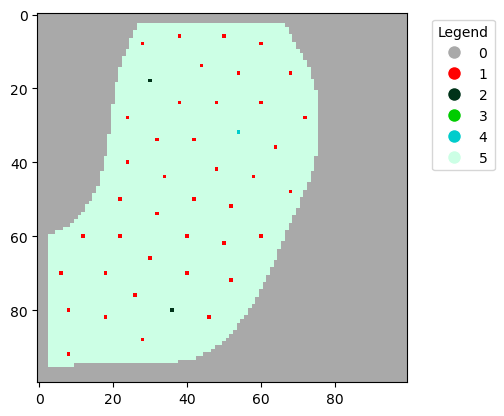

In [129]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteBoundarySpatialEnv(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [130]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan

def make_env(octave):
    def _init():
        return customDiscreteBoundarySpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = VecCheckNan(DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)]), raise_exception=True)

In [131]:
import gc
gc.collect()

24803

In [132]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", 
             envs, 
             n_steps= 10,
             n_epochs= 5,
             batch_size= 10 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 10

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))


999

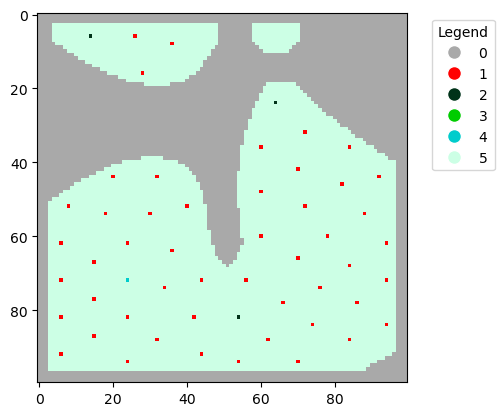

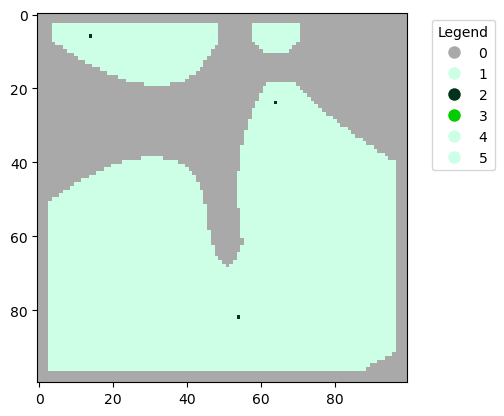

In [134]:
eval_env = customDiscreteBoundarySpatialEnv(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        eval_env.render(True)
        break

In [118]:
model.save('models/PPO_5.zip')

### We start again

In [1]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteDistanceBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteDistanceBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates" : spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 6), dtype=np.int64),
            "Class Ratio": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0)        
        return int(chosen_contour), round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((planting_coords[1], planting_coords[0]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((planting_coords[1], planting_coords[0]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list,
            "Class Ratio": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward -= 50

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward -= 5
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] <= 1:
                        reward += 10*self.class_count[0]

                    elif chosen_value[-4] <= 1: # Near Boundary
                        reward += 8*self.class_count[0]

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 6*self.class_count[0]
                    
                    else:
                        reward += self.class_count[0] + 5
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] <= 2: # Nearer to boundary, penalise
                        reward -= 10
                    else: # Nearer to center, reward
                        reward += 7
                
                # NA Logic
                else:
                    if chosen_value[-4] <= 2: # Nearer to boundary, reward
                        reward += 10
                    else:
                        reward -= 5

                # Check plant density
                density_reward = self._calculate_density_reward(class_value)
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -1].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.025 and class_value==0:
            reward += 5*self.class_count[0]
        
        if self.class_density[1] >= 0.3 and self.class_density[1] <= 0.75 and class_value==1:
            reward += 5**(self.class_density[1])

        if self.class_density[2] >= 0.15 and class_value==2:
            reward -= 5**(self.class_density[2])
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b,c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()



### Testing

In [1]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteDistanceBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteDistanceBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates" : spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 6), dtype=np.int64),
            "Class Ratio": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0)        
        return int(chosen_contour), round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((ratio_coords[0], ratio_coords[1]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((ratio_coords[0], ratio_coords[1]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list,
            "Class Ratio": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward = 0

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward += 1
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] <= 2:
                        reward += 10

                    elif chosen_value[-4] <= 1: # Near Boundary
                        reward += 8

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 6
                    
                    else:
                        reward += 3
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] <= 2: # Nearer to boundary, penalise
                        reward += 1
                    else: # Nearer to center, reward
                        reward += 7
                
                # NA Logic
                else:
                    if chosen_value[-4] <= 2: # Nearer to boundary, reward
                        reward += 7
                    else:
                        reward += 1

                # Check plant density
                density_reward = self._calculate_density_reward(class_value)
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)

        # print(action, reward)
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, -1].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.75:
            reward += 10
        
        if self.class_density[1] <= 0.5 and class_value==1:
            reward += 10

        if self.class_density[2] <= 0.3 and class_value==2:
            reward += 5
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b,c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()



[0 8 0]
[ 6 26]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Class Ratio has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Coordinates has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


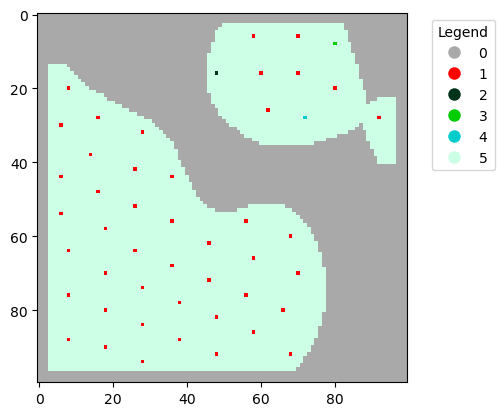

In [2]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteDistanceBoundarySpatialEnv(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [3]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customDiscreteDistanceBoundarySpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)])

In [4]:
import gc
gc.collect()

3502

In [5]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 8,
             n_epochs= 10,
             batch_size= 8 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [6]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 8

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))

Output()

(2.35, 3.0866648668101306)


728
{0: 0.02857142857142857, 1: 0.6857142857142857, 2: 0.2857142857142857}


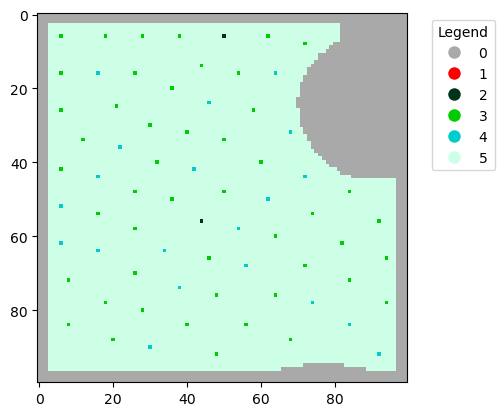

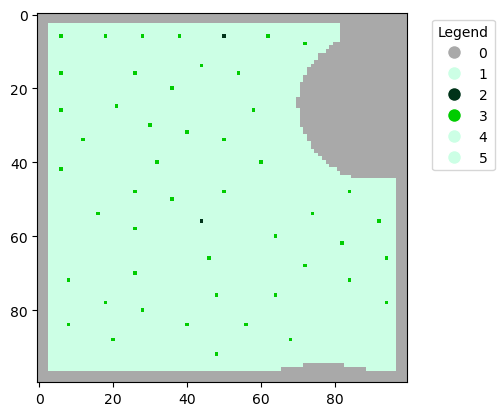

In [9]:
eval_env = customDiscreteDistanceBoundarySpatialEnv(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        print(eval_env.class_density)
        eval_env.render()        
        eval_env.render(True)
        break

In [63]:
model.save('models/PPO_7.zip')

### MultiDiscrete with Contour Lines

In [89]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customDiscreteDistanceBoundarySpatialEnv2(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customDiscreteDistanceBoundarySpatialEnv2, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates" : spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 6), dtype=np.int64),
            "Class Ratio": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 10, 3])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0)        
        return int(chosen_contour), round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((ratio_coords[0], ratio_coords[1]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((ratio_coords[0], ratio_coords[1]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list,
            "Class Ratio": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        contour_value = action[2]
        class_value = action[3]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio, contour_value)
        if chosen_index == -1:
            reward -= 50

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward -= 5
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] <= 1:
                        reward += 10*self.class_count[0]

                    elif chosen_value[-4] <= 1: # Near Boundary
                        reward += 3*self.class_count[0]

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 5*self.class_count[0]
                    
                    else:
                        reward += self.class_count[0]
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] <= 2: # Nearer to boundary, penalise
                        reward -= 7
                    else: # Nearer to center, reward
                        reward += 5
                
                # NA Logic
                else:
                    if chosen_value[-4] <= 2: # Nearer to boundary, reward
                        reward += 5
                    else:
                        reward -= 10

                # Check plant density
                density_reward = self._calculate_density_reward(class_value)
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
            
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int, contour_value:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, 2].astype(int) == contour_value) &
            (self.normalised_planting_list[:, -1].astype(int) == 0))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.05 and class_value==0:
            reward += 5*self.class_count[0]
        
        if self.class_density[1] >= 0.3 and self.class_density[1] <= 0.5 and class_value==1:
            reward += 15**(self.class_density[1])

        if self.class_density[2] >= 0.25 and class_value==2:
            reward -= 30**(self.class_density[2])
        
        return reward

    # def render(self, only_plant:bool=False):
    #     value_to_colour_all = {
    #         0: (169/255, 169/255, 169/255),
    #         1: (1, 0, 0),
    #         2: (0, 51/255, 25/255),
    #         3: (0, 204/255, 0),
    #         4: (0/255, 204/255, 204/255),
    #         5: (204/255, 255/255, 229/255)
    #     }

    #     value_to_colour_plant={
    #         0: (169/255, 169/255, 169/255),
    #         1: (204/255, 255/255, 229/255),
    #         2: (0, 51/255, 25/255),
    #         3: (0, 204/255, 0),
    #         4: (204/255, 255/255, 229/255),
    #         5: (204/255, 255/255, 229/255)
    #     }

    #     img = np.zeros((100, 100, 3))
        
    #     value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
    #     plt.imshow(img)
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    #     plt.show()


    def render(self):
        value_to_colour = {
            0: (169/255, 169/255, 169/255),  # Grey
            1: (1, 0, 0),                   # Red
            2: (0, 51/255, 25/255),          # Dark green
            3: (0, 204/255, 0),              # Bright green
            4: (0/255, 204/255, 204/255),    # Cyan
            5: (204/255, 255/255, 229/255)   # Light green
        }
        
        img = np.zeros((100, 100, 3))

        # Coloring the grid based on values
        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        # Highlight filled boundary
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
        plt.figure(figsize=(12, 12))

        # Show the grid image
        plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

        # Set proper axis limits to ensure correct placement of labels
        plt.xlim(0, img.shape[1])
        plt.ylim(0, img.shape[0])


        # Plot each coordinate and label them with [a,b]
        for i, coord in enumerate(self.normalised_planting_list):
            a, b, c, d, _, _ = coord
            if a == -1:
                continue  # Skip unclassifiable points
            else:
                x,y = self.obv_planting_coordinates[i]
                # Add 0.5 to place text in the center of the cell
                plt.text(x, y, f"{a,b, c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()



[1 9 7 1]
[8 8]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Class Ratio has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation Coordinates has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


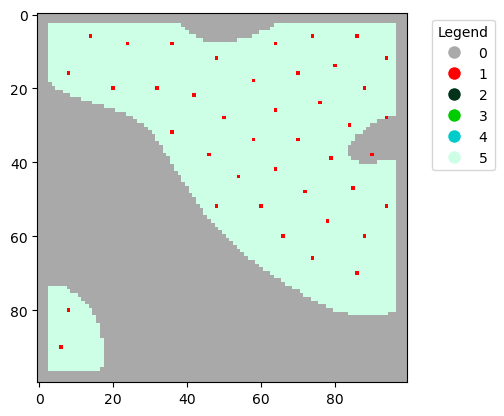

In [16]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customDiscreteDistanceBoundarySpatialEnv2(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [17]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env2(octave):
    def _init():
        return customDiscreteDistanceBoundarySpatialEnv2(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs2 = DummyVecEnv([make_env2(random.uniform(1,2)) for env in range(30)])

In [21]:
import gc
gc.collect()

7

In [20]:
from stable_baselines3 import PPO

model2 = PPO("MultiInputPolicy", 
             envs2, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [22]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 10

model2.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model2, envs2, n_eval_episodes=20, warn=False))

Output()

(-49972.5, 32.53843880704789)


999


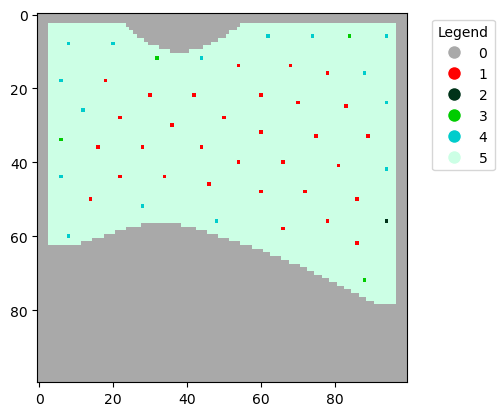

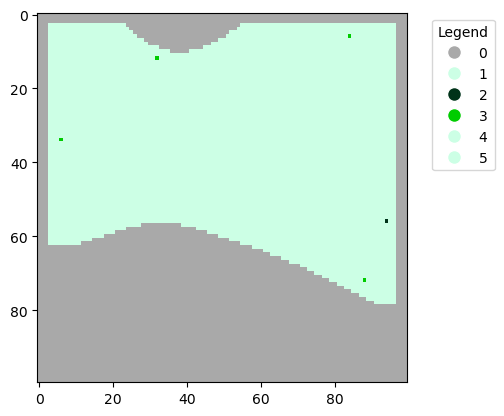

In [32]:
eval_env2 = customDiscreteDistanceBoundarySpatialEnv2(random.uniform(1,2))
obs, info = eval_env2.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model2.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env2.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env2.render()        
        eval_env2.render(True)
        break

In [33]:
model.save('models/PPO_WHY.zip')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# Perform a distance transform on the binary grid (assuming '1' are the inside areas)
distances = distance_transform_edt(test.filled_boundary)

# Define contour levels, e.g., every 10 units of distance
contour_levels = np.arange(0, np.max(distances), step=3)

data = []

for coord in test.normalised_planting_list:
    dist = distances[int(round(coord[2]*10)), int(round(coord[3]*10))]  # Get the distance for the coordinate
    # Find the closest contour level
    closest_contour = contour_levels[np.abs(contour_levels - dist).argmin()]
    data.append([int(round(coord[2]*10)), int(round(coord[3]*10)), closest_contour])

# Plot the grid with contour lines
plt.figure(figsize=(8, 8))
plt.imshow(test.filled_boundary, cmap='Greys', interpolation='none')

# Add contour lines based on distance
contour = plt.contour(distances, levels=contour_levels, colors='blue', linewidths=1)
plt.clabel(contour, inline=True, fontsize=8)  # Label the contour levels

for coord in data:
    plt.plot(coord[0], coord[1], 'ro')  # Red points for coordinates

plt.show()


### Continuous Space

In [82]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class customContinuousDistanceBoundarySpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customContinuousDistanceBoundarySpatialEnv, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Dict(
            {
            "Coordinates" : spaces.Box(low=-1, high=10, shape=(self.maximum_planting_spots, 6), dtype=np.float32),
            "Class Ratio": spaces.Box(low=0, high=1, shape=(3,1), dtype=np.float32)
            }
        )
        # Determine if wna include contour as a action sapce
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = round((xcoord-boundary[0]) / x_length, 4)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = round((ycoord-boundary[2]) / y_length, 4)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0)        
        return chosen_contour, round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((planting_coords[1], planting_coords[0]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((planting_coords[1], planting_coords[0]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list

    def _get_observation(self):
        return {
            "Coordinates": self.normalised_planting_list,
            "Class Ratio": np.array(list(self.class_density.values())).reshape(3,1).astype(np.float32)
        }


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        class_value = action[2]

        # Classify class
        if class_value < 0.45:
            class_value = 0 # tree
        
        elif class_value < 0.9:
            class_value = 1 # shrub
        
        else:
            class_value = 2 # n.a

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio)
        if chosen_index == -1:
            reward -= 50

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if class_value == 0 and chosen_value[-2] == 0:
                reward += 1
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = class_value + 2
                self.class_count[class_value] += 1
                self.normalised_planting_list[chosen_index][-1] = 1

                # Tree Logic
                if class_value == 0:
                    self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                    # Tree Plantable (from prev checking)
                    if chosen_value[-3] == 1 and chosen_value[-4] <= 2:
                        reward += 10

                    elif chosen_value[-4] <= 1: # Near Boundary
                        reward += 8

                    elif chosen_value[-3] == 1: # Near Curve but not near boundary
                        reward += 6
                    
                    else:
                        reward += 3
                    # Update plantable
                    self._update_tree_distance()

                # Shrub Logic
                elif class_value == 1:
                    if chosen_value[-4] <= 2: # Nearer to boundary, penalise
                        reward += 1
                    else: # Nearer to center, reward
                        reward += 5
                
                # NA Logic
                else:
                    if chosen_value[-4] <= 2: # Nearer to boundary, reward
                        reward += 7
                    else:
                        reward += 1

                                # Check plant density
                
                density_reward = self._calculate_density_reward()
                reward += density_reward

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)
            
        done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1]))) or self.current_step >= self.max_step
        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int):
        plantable_coordinates_indexes = np.where(self.normalised_planting_list[:, -1] == 0)[0]
        plantable_coordinates_ratio = self.normalised_planting_list[plantable_coordinates_indexes][:, :2]

        # Calculate distance of all plantable coordinates to RL action
        distances = cdist(np.array([[yratio, xratio]]), plantable_coordinates_ratio, metric='euclidean').flatten()
        # Step 4: Find the index where the minimum distance is >= 0.2
        min_distance_index = np.argmin(distances)
        if distances[min_distance_index] <= 0.15:
            closest_index = plantable_coordinates_indexes[min_distance_index]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self):
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.2:
            reward += 10
        
        if self.class_density[1] >= 0.5:
            reward += 5

        if self.class_density[2] <= 0.4:
            reward += 3
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b,c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()



[0.8447691  0.7252039  0.28981665]
[6 6]


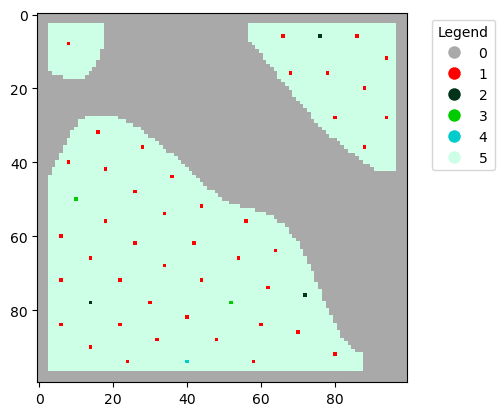

In [83]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = customContinuousDistanceBoundarySpatialEnv(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [84]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customContinuousDistanceBoundarySpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)])

In [85]:
import gc
gc.collect()

4802

In [86]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 8,
             n_epochs= 10,
             batch_size= 8 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [88]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 100000
total_timesteps = max_runs* 8

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))

Output()

(-49788.2, 79.35212662556687)


165


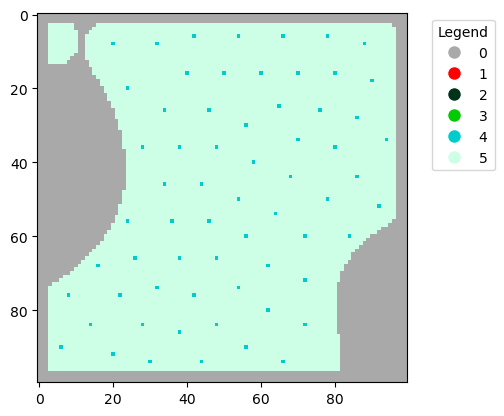

In [94]:
eval_env = customContinuousDistanceBoundarySpatialEnv(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        eval_env.render()
        break

### Maximise Trees

In [4]:
import numpy as np
import cv2
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Environment Class
class MaximiseTrees(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(MaximiseTrees, self).__init__()
        # Steps
        self.current_step = 0
        self.max_step = 1000

        # Base Variables
        self.minimum_distance = 10
        self.padded_boundary = 5
        self.contour_distance = 5

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        
        # Embedding planting coordinates and padding
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)

        # Class data
        self.tree_coordinates = [] # Will be y,x coordinate because of self.planting_coordinates being y,x
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Observation space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 6), dtype=np.int64),

        # Determine if wna include contour as a action sapce
        self.action_space = spaces.MultiDiscrete([10, 10, 10])
    
   
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 of planting boundary
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])

            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break
        
        boundary_grid, filled_boundary_grid = self._extract_outline(perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def _extract_outline(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the outline of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): Array with boundary of dithered grid
            filled_boundary_grid (np.ndarray): Array with the filled boundary area
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        kernel = np.ones((3,3), np.uint8) # For dilating, expanding the points so that they form a nice boundary blob
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid


    def _get_coordinate_boundary_ratio(self, xcoord:int, ycoord:int):
        """
        Function to generate the x and y ratio of the coordinate to the boundary from the left and top

        Args:
            xcoord (int): x coordinate of planting spot
            ycoord (int): y coordinate of planting spot

        Returns:
            (ratio_x, ratio_y) (tuple)
        """
        boundary = [] #[xleft, xright, ytop, ybottom]

        # Checking x coordinate ratio
        for x in range(xcoord, -1, -1): 
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x == 0:
                boundary.append(x)
        
        for x in range(xcoord, self.grid_size[0]):
            if self.boundary[ycoord, x] == 1: # boundary
                boundary.append(x)
                break
            elif x  == (self.grid_size[0] - 1):
                boundary.append(x)

        # Checking y coordinate ratio
        for y in range(ycoord, -1, -1): 
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == 0:
                boundary.append(y)
        
        for y in range(ycoord, self.grid_size[1]):
            if self.boundary[y, xcoord] == 1: # boundary
                boundary.append(y)
                break
            elif y == (self.grid_size[1] - 1):
                boundary.append(y)

        try:
            # Retrieve ratio
            x_length = max(boundary[1] - boundary[0], 1)
            ratio_x = int(round((xcoord-boundary[0]) / x_length, 4)*10)
            
            y_length = max(boundary[3] - boundary[2], 1)
            ratio_y = int(round((ycoord-boundary[2]) / y_length, 4)*10)
            return (ratio_x, ratio_y)
        except:
            print(boundary, xcoord, ycoord)


    def _get_contours(self, xcoord:int, ycoord:int):
        grid_distance = distance_transform_edt(self.filled_boundary)
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0)        
        return int(chosen_contour), round(coordinate_distance, 4)


    def _get_near_curve(self, curve_distance:dict, ratio_list:list):
        # Assume all are curves
        boundary_list = [1] * len(ratio_list)

        for value_list in curve_distance.values():
            # No duplicates
            if len(value_list) <= 1:
                continue
            # Multiple coordinate with same distance
            else:
                seen_x = set()
                seen_y = set()
                for x, y in value_list:
                    # Check if vertically or horizontally aligned coordinates have the same distance, if yes likely in a straight line
                    if x in seen_x or y in seen_y:
                        ratio_index = ratio_list.index((x,y))
                        boundary_list[ratio_index] = 0
                    seen_x.add(x)
                    seen_y.add(y)
                
        return boundary_list


    def _embed_coordinates(self, planting_coordinates:np.ndarray, num_plants:int):
        """
        Function to convert planting coordinates into their respective embedding
        [xratio from boundary, yratio from boundary, contour line value, boundary?, tree plantable?, classified?] -> [0-9, 0-9, 0-9, 0/1, 0/1, 0/1]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1)

        Args:
            planting_coordinates (np.ndarray): Numpy array of all planting coordinates
            num_plants (int): Length of the normalised planting list
        Returns:
            normalised_planting_list (np.ndarray): Numpy array of all embeded planting cordinates, padded coordinates are (-1,-1)
        """
        curve_distance = {}
        ratio_list = []

        # Padded
        normalised_planting_list = np.full((num_plants, 6), -1, dtype=np.float32)  # Initialize with (-1, -1, -1, -1, -1, -1)
        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(planting_coordinates): #planting coords is (y,x)
            ratio_coords = self._get_coordinate_boundary_ratio(planting_coords[1], planting_coords[0])
            contour_value, contour_dist = self._get_contours(planting_coords[1], planting_coords[0])
            # Update distance in the distance dictionary 
            distance_coord_list = curve_distance.get(contour_dist, [])
            distance_coord_list.append((planting_coords[1], planting_coords[0]))
            curve_distance[contour_dist] = distance_coord_list
            ratio_list.append((planting_coords[1], planting_coords[0]))
            # Update data
            normalised_planting_list[i] = ratio_coords + (contour_value, 0) + (1, 0)
            self.obv_planting_coordinates[i] = (planting_coords[1], planting_coords[0])
        
        boundary_list = self._get_near_curve(curve_distance, ratio_list)
        normalised_planting_list[:len(boundary_list), 3] = boundary_list
        return normalised_planting_list.astype(np.int64)


    def _get_observation(self):
        return self.normalised_planting_list


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.obv_planting_coordinates = {}
        self.curve_distance = []
        self.tree_coordinates = [] 
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self._create_environment()
        self.normalised_planting_list = self._embed_coordinates(self.planting_coordinates, self.maximum_planting_spots)
        return self._get_observation() , {}


    def step(self, action):
        self.current_step += 1
        reward = 0
        done=False

        # Decode action
        x_ratio = action[0]
        y_ratio = action[1]
        contour_value = action[2]

        chosen_index = self._retrieve_closest_coordinate(x_ratio, y_ratio, contour_value)
        if chosen_index == -1:
            reward -= 1

        else: 
            # Update grid, class count and planting list to now be planted
            chosen_value = self.normalised_planting_list[chosen_index]

            # Unplantable Tree, do not update grid
            if chosen_value[-2] == 0:
                done = True
            
            # Plantable, update grid
            else:
                chosen_coordinates = self.obv_planting_coordinates[chosen_index]
                self.grid[chosen_coordinates[1], chosen_coordinates[0]] = 2
                self.normalised_planting_list[chosen_index][-1] = 1

                self.tree_coordinates.append((chosen_coordinates[1], chosen_coordinates[0]))
                # Tree Plantable (from prev checking)
                if chosen_value[-3] == 1 and chosen_value[-4] <= 1:
                    reward += 2

                else:
                    reward += 1
                # Update plantable
                self._update_tree_distance()
                done = bool(np.all(np.isin(self.normalised_planting_list[:, -1], [1, -1])))

            # if self.current_step > 200:
            #     reward -= 1/10* (self.current_step-200)

        return self._get_observation(), reward, done ,False, {}


    def _retrieve_closest_coordinate(self, xratio:int, yratio:int, contour_value:int):
        # Pick the closest plantable coordinate
        filtered_data = self.normalised_planting_list[
            ((self.normalised_planting_list[:, 0].astype(int) == xratio) &
            (self.normalised_planting_list[:, 1].astype(int) == yratio) &
            (self.normalised_planting_list[:, 2].astype(int) == contour_value))
        ]
        if filtered_data.size > 0:
            closest_index = np.where(np.all(self.normalised_planting_list == filtered_data[0], axis=1))[0][0]

        else:
            closest_index = -1

        return closest_index
    

    def _update_tree_distance(self):
        tree_coordinates = np.array(self.tree_coordinates)
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < 50:
                # No longer plantable
                self.normalised_planting_list[index][-2] = 0


    def _calculate_density_reward(self, class_value):
        total_count = len(self.planting_coordinates)
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density
        
        reward = 0
        if self.class_density[0] >= 0.2:
            reward += 1
        
        # if self.class_density[1] >= 0.3 and self.class_density[1] <= 0.75 and class_value==1:
        #     reward += 5**(self.class_density[1])

        # if self.class_density[2] >= 0.15 and class_value==2:
        #     reward -= 5**(self.class_density[2])
        
        return reward

    def render(self, only_plant:bool=False):
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }

        img = np.zeros((100, 100, 3))
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        for value, color in value_to_colour.items():
            img[self.grid == value] = color

        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
                
        plt.imshow(img)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


    # def render(self):
    #     value_to_colour = {
    #         0: (169/255, 169/255, 169/255),  # Grey
    #         1: (1, 0, 0),                   # Red
    #         2: (0, 51/255, 25/255),          # Dark green
    #         3: (0, 204/255, 0),              # Bright green
    #         4: (0/255, 204/255, 204/255),    # Cyan
    #         5: (204/255, 255/255, 229/255)   # Light green
    #     }
        
    #     img = np.zeros((100, 100, 3))

    #     # Coloring the grid based on values
    #     for value, color in value_to_colour.items():
    #         img[self.grid == value] = color

    #     # Highlight filled boundary
    #     img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]
    #     plt.figure(figsize=(12, 12))

    #     # Show the grid image
    #     plt.imshow(img, origin='lower')  # Set origin to lower to align with the grid's coordinate system

    #     # Set proper axis limits to ensure correct placement of labels
    #     plt.xlim(0, img.shape[1])
    #     plt.ylim(0, img.shape[0])


    #     # Plot each coordinate and label them with [a,b]
    #     for i, coord in enumerate(self.normalised_planting_list):
    #         a, b, c, d, _, _ = coord
    #         if a == -1:
    #             continue  # Skip unclassifiable points
    #         else:
    #             x,y = self.obv_planting_coordinates[i]
    #             # Add 0.5 to place text in the center of the cell
    #             plt.text(x, y, f"{a,b,c, d}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')

    #     # Add legend
    #     handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
    #     labels = list(value_to_colour.keys())
    #     plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

    #     plt.show()



[1 1 0]
[ 6 10]


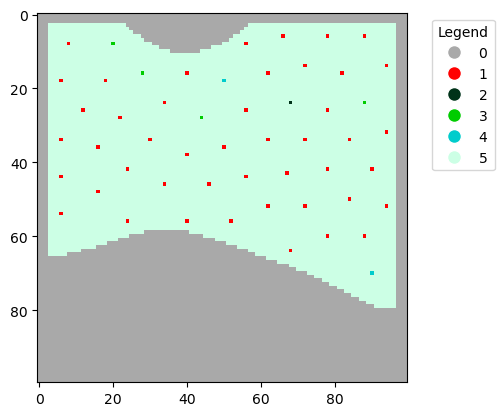

In [6]:
from stable_baselines3.common.env_checker import check_env

# TEST EXAMPLE
test = MaximiseTrees(random.uniform(1,2))
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

In [7]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return MaximiseTrees(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(30)])

In [8]:
import gc
gc.collect()

7423

In [9]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", 
             envs, 
             n_steps= 8,
             n_epochs= 10,
             batch_size= 8 * 30,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [10]:
from stable_baselines3.common.evaluation import evaluate_policy
max_runs = 10000
total_timesteps = max_runs* 8

model.learn(total_timesteps=total_timesteps, progress_bar=True)
print(evaluate_policy(model, envs, n_eval_episodes=20, warn=False))

Output()

KeyboardInterrupt: 

3

{0: 0.037037037037037035, 1: 0.0, 2: 0.0}

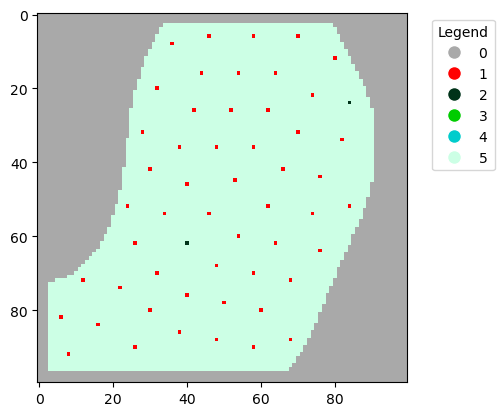

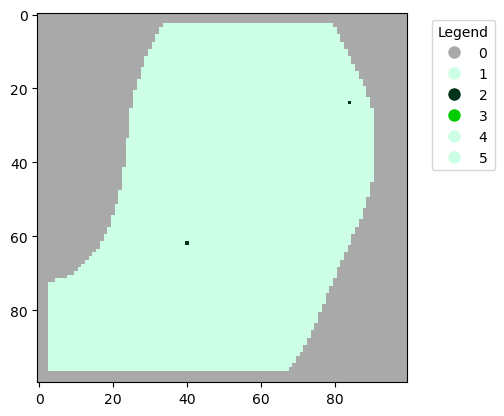

In [15]:
eval_env = MaximiseTrees(random.uniform(1,2))
obs, info = eval_env.reset(None, None)
total_reward = 0

for i in range(1000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    if done:
        print(i)
        print(eval_env.class_density)
        eval_env.render()        
        eval_env.render(True)
        break

In [3]:
import numpy as np
from scipy.ndimage import label, center_of_mass

# Example array
array = np.array([
    [0, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1]
])

# Label each connected component of 1s
labeled_array, num_features = label(array)

# Prepare an array to store distances from the center of each area
distance_from_center = np.zeros_like(array, dtype=float)

# For each labeled component, calculate distances from the centroid
for label_num in range(1, num_features + 1):
    # Find the centroid of the current component
    centroid = center_of_mass(array, labeled_array, label_num)
    # Create a mask for the current component
    mask = labeled_array == label_num
    # Get the coordinates of points in the current component
    coords = np.argwhere(mask)
    # Calculate distances from the centroid for each point in the component
    for coord in coords:
        distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
        distance_from_center[tuple(coord)] = distance

# Round distances to the nearest integer
distance_from_center = np.round(distance_from_center).astype(int)

print("Rounded distance from center for each area:\n", distance_from_center)


Rounded distance from center for each area:
 [[0 1 1 0 0]
 [1 0 1 0 0]
 [0 0 0 1 1]
 [0 0 0 1 1]]
